## Get imputed data from palantir's algo (MAGIC)

In [1]:
import scvelo as scv
import scanpy as sc
import velocyto as vcy
import cellrank as cr
import loompy as lp

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from pathlib import Path

import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt

import os
import sys
import logging

In [2]:
# load file path from ocean
adata_infile = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/outs/adata_aggregated_gene.leiden.h5ad'

In [3]:
# transfer the file to the scratch space
!rsync -aP $adata_infile /dev/shm/

sending incremental file list
adata_aggregated_gene.leiden.h5ad
  1,932,669,800 100%  387.29MB/s    0:00:04 (xfr#1, to-chk=0/1)


In [31]:
adata = sc.read_h5ad('/dev/shm/adata_aggregated_gene.leiden.h5ad')

In [32]:
adata

AnnData object with n_obs × n_vars = 32418 × 23090
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap', 'X_umap_features'
    varm: 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'counts'
    obsp: 'connectivities',

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


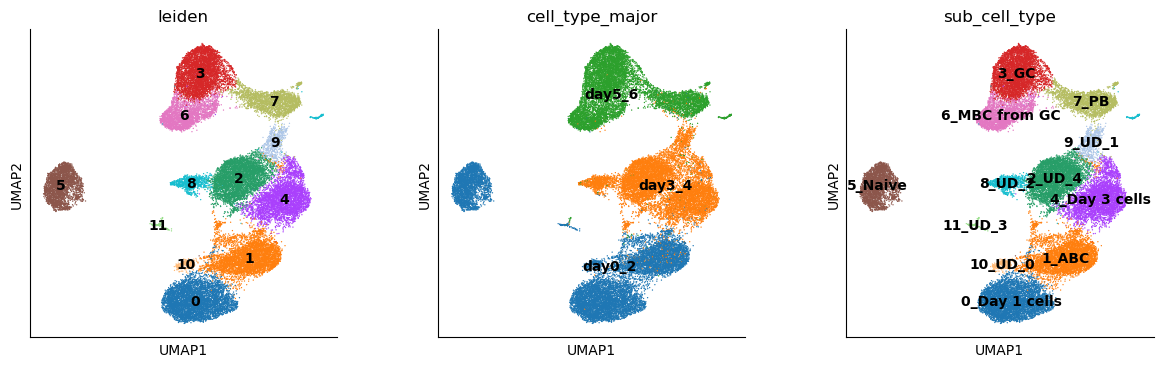

In [33]:
cluster_list = list(set(adata.obs.leiden))
# Annotation 2
annotation_2 = {'5': '5_Naive',
                '10': '10_UD_0',
                '9': '9_UD_1',
                '8': '8_UD_2',
                '3': '3_GC',
                '11': '11_UD_3',
                '1': '1_ABC',
                '0': '0_Day 1 cells',
                '7': '7_PB',
                '4': '4_Day 3 cells',
                '6': '6_MBC from GC',
                '2': '2_UD_4'}
adata.obs["sub_cell_type"] = [annotation_2[i] for i in adata.obs.leiden]
sc.pl.umap(adata, color=['leiden','cell_type_major','sub_cell_type'],legend_loc='on data')

In [34]:
# remove Naive (5) and Day 1 cells (0) for analysis of day2+ cells; 
cell_clusters_to_keep = ['1', '2', '3', '4', '6', '7', '8','9', '10', '11']
adata_subset = adata[adata.obs['leiden'].isin(cell_clusters_to_keep)]
adata_subset

View of AnnData object with n_obs × n_vars = 24315 × 23090
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'sub_cell_type_colors'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap', 'X_umap_features'
    varm: 'topic_feature_activations', 'topic_feature_compositions'

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


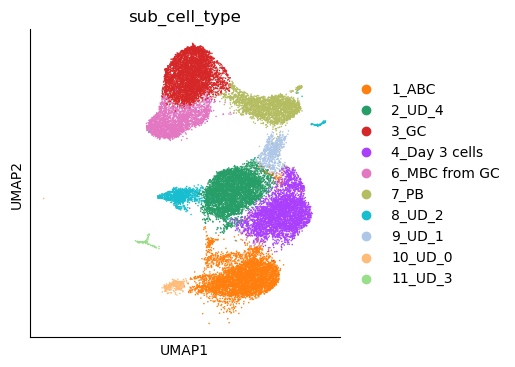

In [35]:
# Plot UMAP post filtering cells
sc.pl.umap(adata_subset, color='sub_cell_type')

In [36]:
adata_subset.X = adata_subset.layers['counts']

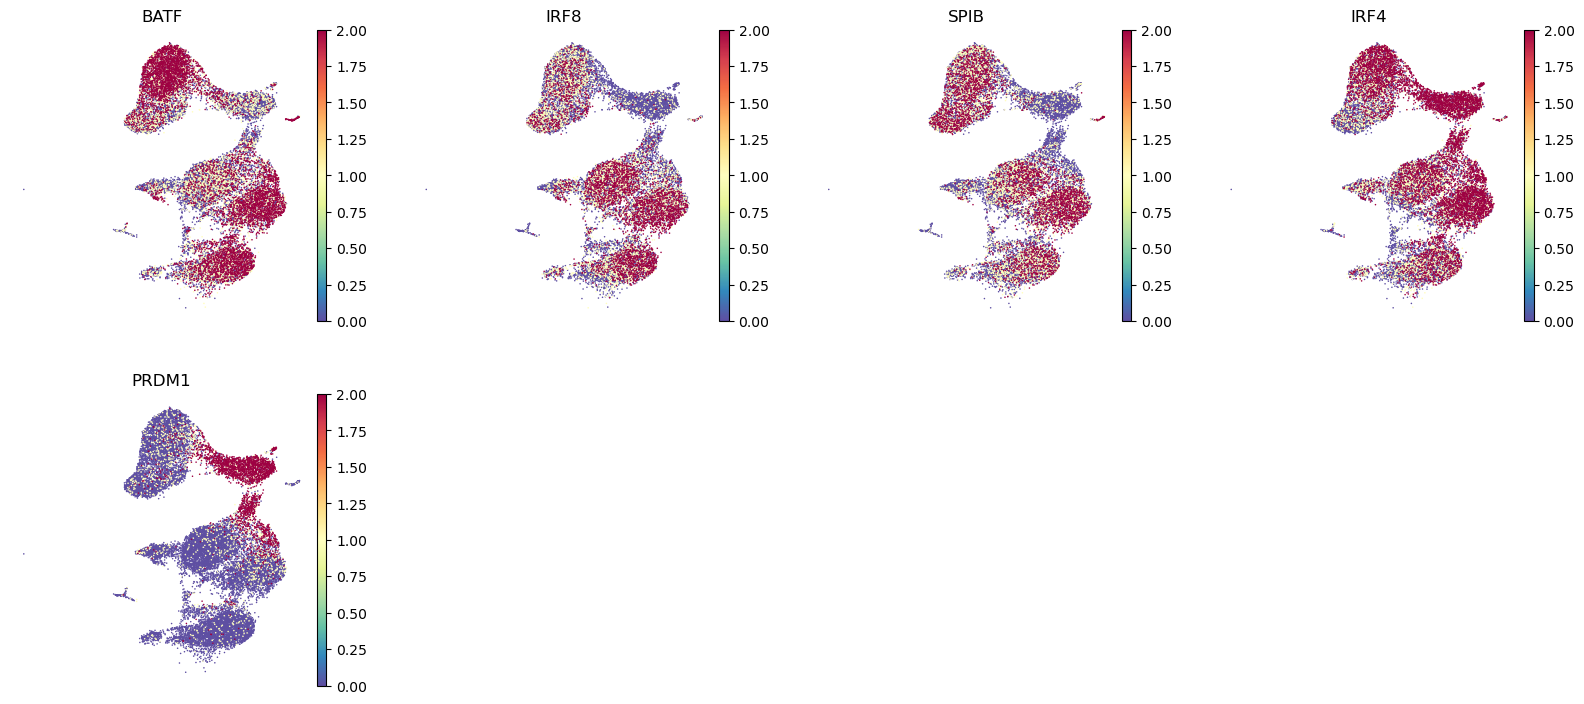

In [22]:
# pre imputation expression of 5 TFs
sc.pl.embedding(
    adata_subset,
    basis="umap",
    layer="counts",
    color=["BATF","IRF8","SPIB","IRF4","PRDM1"],
    vmin=0,
    vmax=2,
    frameon=False,
)
plt.show()

#### Impute all genes using MAGIC API (bad results)

In [7]:
import magic
import scprep

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Matplotlib command for Jupyter notebooks only
%matplotlib inline

In [8]:
magic_op = magic.MAGIC()

In [9]:
# impute using all genes
bcell_magic = magic_op.fit_transform(adata_subset, genes="all_genes")

Calculating MAGIC...
  Running MAGIC on 32418 cells and 23090 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 29.50 seconds.
    Calculating KNN search...
    Calculated KNN search in 93.61 seconds.
    Calculating affinities...
    Calculated affinities in 93.32 seconds.
  Calculated graph and diffusion operator in 216.46 seconds.
  Running MAGIC with `solver='exact'` on 23090-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 37.99 seconds.
Calculated MAGIC in 255.49 seconds.


In [12]:
bcell_magic.shape


(32418, 23090)

In [13]:
adata_subset.layers["magic_imputed"] = bcell_magic.X
# Save the updated AnnData object
adata_subset.write_h5ad("/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/bcell_magic_imputed.h5ad")

In [14]:
adata_subset.X = adata_subset.layers["magic_imputed"]

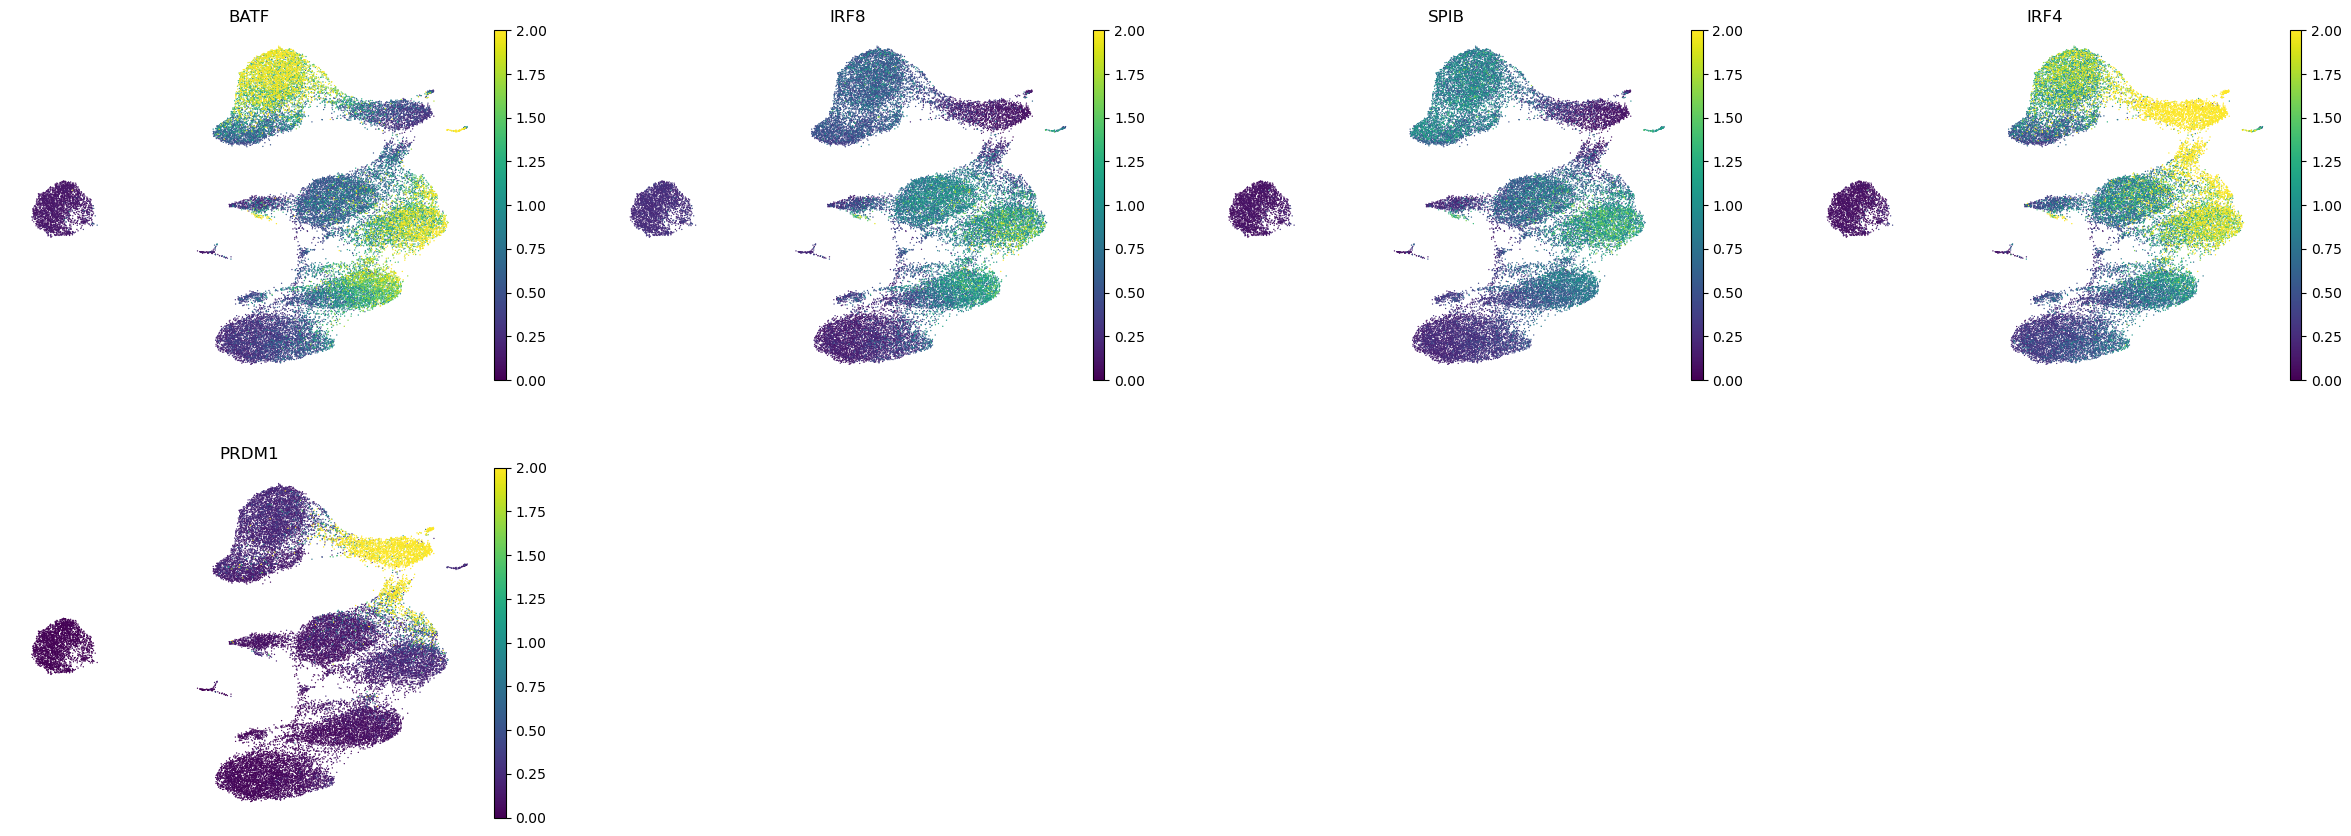

In [15]:
# plot post imputation expression of 5 TFs
sc.pl.embedding(
    adata_subset,
    basis="umap",
    layer="magic_imputed",
    color=["BATF","IRF8","SPIB","IRF4","PRDM1"],
    vmin=0,
    vmax=2,
    frameon=False,
)

#### Impute only highly variable genes by using diffusion in the pca space of cells to get new nearest neighbors

In [37]:
import palantir

In [38]:
def feature_selection(adata, gene_list = None):
    sc.pp.highly_variable_genes(adata, flavor='cell_ranger',n_top_genes=3000) 
    # MODIFY FILTERED_GENES TO ADD GENES OF INTEREST
    # Overriding the bool_list to include TF of interest
    if gene_list is not None:
        for gene in gene_list:
            if adata.var['highly_variable'][gene] == False:
                adata.var['highly_variable'][gene] = True
    #subset the anndata for faster downstream calculations 
    adata = adata[:, adata.var.highly_variable]
    return adata

In [39]:
TFs_of_importance = ["BATF","IRF8","SPIB","IRF4","PRDM1"]
marker_list = ["IL10", "AICDA", "IL4R", "FCER2", "BCL6", "JUN", "CD69", "JCHAIN", "CD27", "CD38", "XBP1", "MZB1", "MKI67"]
TF_perturb_list = ["BATF3","EGR1","FOS","IKZF1","IRF1","JUNB","JUND","MEF2A","MEF2C","MYB","NFATC1","NFATC2","NFIL3","NFKB1","NFKB2","PAX5","RUNX1","SP3","SPI1","STAT1","STAT5A","TCF12","VDR","XBP1","ZBTB7A"]
gene_list = list(set(marker_list).union(set(TF_perturb_list)).union(set(TFs_of_importance)))
adata_subset = feature_selection(adata_subset, gene_list) 

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:553: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [40]:
# check if new adata has var names of interest from the TFs_of_importance list
print(adata_subset.var.highly_variable[TFs_of_importance])
adata_subset


BATF     True
IRF8     True
SPIB     True
IRF4     True
PRDM1    True
Name: highly_variable, dtype: bool


View of AnnData object with n_obs × n_vars = 24315 × 3025
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'sub_cell_type_colors', 'hvg'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap', 'X_umap_features

#### Run PCA to reduce dimensionality for diffusion step recalculation of cell-cell similarities

In [41]:
# default pca function gives bad results (palantir.utils.run_pca(adata, n_components=50))
def dim_reduction(adata):
    #Scale before running PCA
    sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
    sc.pp.scale(adata, max_value=10)
    sc.pp.pca(adata)
    sc.pl.pca_variance_ratio(adata, n_pcs=20, log=True)
    return adata

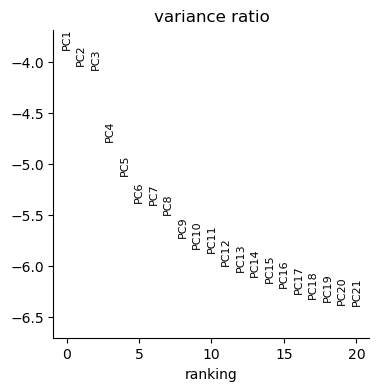

AnnData object with n_obs × n_vars = 24315 × 3025
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'sub_cell_type_colors', 'hvg', 'pca'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap', 'X

In [42]:
adata_subset = dim_reduction(adata_subset)
adata_subset

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


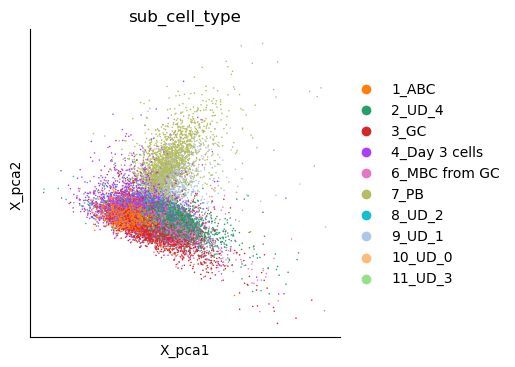

In [43]:
# plot using X_pca
sc.pl.embedding(adata_subset, basis='X_pca', color=['sub_cell_type'])


#### Run diffusion maps to get cell-cell similarities

In [44]:
palantir.utils.run_diffusion_maps(adata_subset,n_components=4) #knn = 30 by default for graph construction

{'T': <24315x24315 sparse matrix of type '<class 'numpy.float64'>'
 	with 1268902 stored elements in Compressed Sparse Row format>,
 'EigenVectors':                            0         1         2         3
 AAACAGCCAAGCCACT-3 -0.006413 -0.000620  0.001341 -0.011567
 AAACAGCCAAGGTGCA-1 -0.006413 -0.000307  0.003490  0.002263
 AAACAGCCAATTATGC-2 -0.006413 -0.000411  0.002277  0.003594
 AAACAGCCATTCAGCA-3 -0.006413 -0.000546  0.001491 -0.009430
 AAACATGCAAAGCTCC-1 -0.006413 -0.000291  0.003693  0.002957
 ...                      ...       ...       ...       ...
 TTTGTTGGTTATCCGT-3 -0.006413 -0.000556 -0.021624  0.001983
 TTTGTTGGTTGACTTC-1 -0.006413 -0.000325  0.003845  0.003562
 TTTGTTGGTTTATGGG-2 -0.006413 -0.000327  0.002559  0.002953
 TTTGTTGGTTTCCTCC-3 -0.006413 -0.000657  0.001055 -0.011908
 TTTGTTGGTTTGAGGC-2 -0.006413 -0.000396 -0.000006  0.004458
 
 [24315 rows x 4 columns],
 'EigenValues': 0    1.000000
 1    0.989098
 2    0.982290
 3    0.975193
 dtype: float64,
 'kernel': 

In [45]:
adata_subset

AnnData object with n_obs × n_vars = 24315 × 3025
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'sub_cell_type_colors', 'hvg', 'pca', 'DM_EigenValues'
    obsm: 'X_joint_umap_features', 'X_topic_compositi

#### Run imputation 

In [48]:
palantir.utils.run_magic_imputation(adata_subset)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.40271407, ..., 0.01201074, 0.01140233,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02847488, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.22331364, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

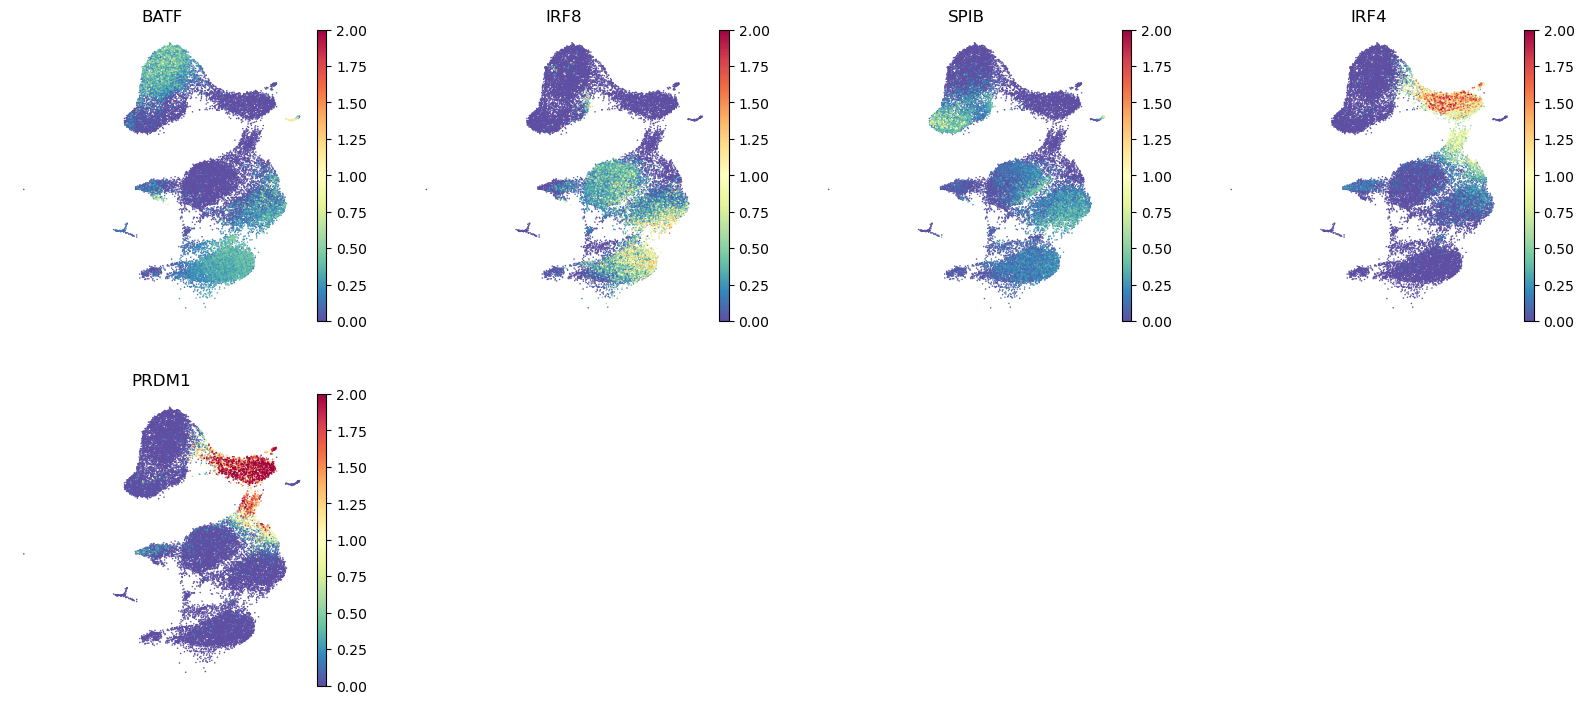

In [50]:
# plot post imputation expression of 5 TFs
sc.pl.embedding(
    adata_subset,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["BATF","IRF8","SPIB","IRF4","PRDM1"],
    vmin=0,
    vmax=2,
    frameon=False,
)
plt.show()


In [51]:
# save the updated adata_subset
adata_subset.write_h5ad("/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/bcell_magic_imputed_subset.h5ad")
